In [1]:
import kagglehub

In [2]:
# Download Dataset
data_dir = kagglehub.dataset_download('andrewmvd/dog-and-cat-detection')
print(f"Path to Dataset: {data_dir}")

Path to Dataset: /kaggle/input/dog-and-cat-detection


In [3]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights

# Data Visualizer
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Data Reader
import xml.etree.ElementTree as ET

import time

----------------------------

# **Sample Data**

In [4]:
sample_annotation = '/kaggle/input/dog-and-cat-detection/annotations/Cats_Test0.xml'
sample_tree = ET.parse(sample_annotation)
sample_root = sample_tree.getroot()

for element in sample_root:
    print(f"{element} is an element in {sample_annotation}")

folder_tag = sample_root.findall('folder')
filename_tag = sample_root.findall('filename')
size_tag = sample_root.findall('size')
segmented_tag = sample_root.findall('segmented')
object_tag = sample_root.findall('object')
print("-"*59)
print(f"Type of folder_tag is: {type(folder_tag)}")
print(f"Type of filename_tag is: {type(filename_tag)}")
print(f"Type of size_tag is: {type(size_tag)}")
print(f"Type of segmented_tag is: {type(segmented_tag)}")
print(f"Type of object_tag is: {type(object_tag)}")

<Element 'folder' at 0x7e2593fde8e0> is an element in /kaggle/input/dog-and-cat-detection/annotations/Cats_Test0.xml
<Element 'filename' at 0x7e2593fde930> is an element in /kaggle/input/dog-and-cat-detection/annotations/Cats_Test0.xml
<Element 'size' at 0x7e2593fde980> is an element in /kaggle/input/dog-and-cat-detection/annotations/Cats_Test0.xml
<Element 'segmented' at 0x7e2593fdeac0> is an element in /kaggle/input/dog-and-cat-detection/annotations/Cats_Test0.xml
<Element 'object' at 0x7e2593fdeb10> is an element in /kaggle/input/dog-and-cat-detection/annotations/Cats_Test0.xml
-----------------------------------------------------------
Type of folder_tag is: <class 'list'>
Type of filename_tag is: <class 'list'>
Type of size_tag is: <class 'list'>
Type of segmented_tag is: <class 'list'>
Type of object_tag is: <class 'list'>


In [5]:
for element in folder_tag[0]:
    print(f"{element} is an element in folder_tag")
print("-"*59)

for element in filename_tag[0]:
    print(f"{element} is an element in filename_tag")
print("-"*59)

for element in size_tag[0]:
    print(f"{element} is an element in size_tag")
print("-"*59)

for i in segmented_tag[0]:
    print(f"{element} is an element in segmented_tag")
print("-"*59)

for element in object_tag[0]:
    print(f"{element} is an element in object_tag")

-----------------------------------------------------------
-----------------------------------------------------------
<Element 'width' at 0x7e2593fde9d0> is an element in size_tag
<Element 'height' at 0x7e2593fdea20> is an element in size_tag
<Element 'depth' at 0x7e2593fdea70> is an element in size_tag
-----------------------------------------------------------
-----------------------------------------------------------
<Element 'name' at 0x7e2593fdeb60> is an element in object_tag
<Element 'pose' at 0x7e2593fdebb0> is an element in object_tag
<Element 'truncated' at 0x7e2593fdec00> is an element in object_tag
<Element 'occluded' at 0x7e2593fdec50> is an element in object_tag
<Element 'difficult' at 0x7e2593fdeca0> is an element in object_tag
<Element 'bndbox' at 0x7e2593fdecf0> is an element in object_tag


In [6]:
for element in object_tag[0][5]:
    print(f"{element} is an element in object_tag")

<Element 'xmin' at 0x7e2593fded40> is an element in object_tag
<Element 'ymin' at 0x7e2593fded90> is an element in object_tag
<Element 'xmax' at 0x7e2593fdede0> is an element in object_tag
<Element 'ymax' at 0x7e2593fdee30> is an element in object_tag


In [7]:
print(object_tag[0][0].text)
print(type(object_tag[0][0].text))

cat
<class 'str'>


In [8]:
print(object_tag[0][5])
print(object_tag[0][5].findall('xmin')[0].text)

<Element 'bndbox' at 0x7e2593fdecf0>
83


# Tree Structure
```
<annotation>
    <folder>images</folder>
    <filename>Cats_Test0.png</filename>
    <size>
        <width>233</width>
        <height>350</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>cat</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>83</xmin>
            <ymin>29</ymin>
            <xmax>197</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
</annotation>

----------------------

# **Dataset**

In [9]:
class ImageDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform = None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_image_files = []

        # Loop through all Image in directory
        for image in sorted(os.listdir(self.image_dir)):
            
            # Check if annotation exists
            if os.path.isfile(os.path.join(self.image_dir, image)):
                annotation_name = os.path.splitext(image)[0] + '.xml'
                annotation_path = os.path.join(self.annotations_dir, annotation_name)
                try:
                    tree = ET.parse(annotation_path)
                    root = tree.getroot()
                    object_tag = root.findall('object')
                    if len(object_tag) <= 1:
                        valid_image_files.append(image)
                    else:
                        print(f"Image {image} has multiple objects and will be excluded from the dataset")
                        print(" ")
                except FileNotFoundError:
                    valid_image_files.append(image)
        return valid_image_files
                    
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Image Path
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Load Image
        image = Image.open(img_path).convert("RGB")

        # Annotation Path
        annotation_name = os.path.splitext(img_name)[0] + '.xml'
        annotation_path = os.path.join(self.annotations_dir, annotation_name)
        try:
            # Parse Annotation
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            label_name = None
            object_tag = root.findall('object')
            
            # We are working with 1 object/image so no need for loop
            name = object_tag[0][0].text
            xmin = int(object_tag[0][5].findall('xmin')[0].text)
            ymin = int(object_tag[0][5].findall('ymin')[0].text)
            xmax = int(object_tag[0][5].findall('xmax')[0].text)
            ymax = int(object_tag[0][5].findall('ymax')[0].text)
            image_width = int(root.find('size/width').text)
            image_height = int(root.find('size/height').text)
            
            bbox = [ # Normalize
                xmin/image_width,
                ymin/image_height,
                xmax/image_width,
                ymax/image_height
            ]
            
            if (label_name is None):
                label_name = name
            label = 0 if label_name == 'cat' else 1 if label_name == 'dog' else -1
        except FileNotFoundError:
            print(f"Annotation file {annotation_name} missing. Assining label as -1")
            label = -1
        

        if self.transform:
            image = self.transform(image)

        return image, label, torch.tensor(bbox, dtype=torch.float32)

In [10]:
# Data Directories
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

# Get list of image files and create dummy dataframe to split the data
image_files = [image for image in sorted(os.listdir(image_dir)) if os.path.isfile(os.path.join(image_dir, image))]
df = pd.DataFrame({'image_name': image_files})
print(f"Dummy Dataset:")
print(df.head())
print("-"*59)

# Split data
train_df, val_df = train_test_split(df, test_size = .2, random_state = 42)
print(f"Train Dataset:")
print(train_df.head())
print("-"*59)
print(f"Validation Dataset:")
print(val_df.head())

Dummy Dataset:
          image_name
0     Cats_Test0.png
1     Cats_Test1.png
2    Cats_Test10.png
3   Cats_Test100.png
4  Cats_Test1000.png
-----------------------------------------------------------
Train Dataset:
             image_name
2676  Cats_Test3406.png
776   Cats_Test1697.png
3454   Cats_Test790.png
25     Cats_Test102.png
1377  Cats_Test2237.png
-----------------------------------------------------------
Validation Dataset:
             image_name
3554   Cats_Test880.png
3081   Cats_Test454.png
2969  Cats_Test3670.png
2114  Cats_Test2900.png
3347   Cats_Test694.png


In [11]:
# Augmentation/Transforms

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
        )
    ]
)

# Datasets
train_set = ImageDataset(annotations_dir, image_dir, transform = transform)
val_set = ImageDataset(annotations_dir, image_dir, transform = transform)

# Filter datasets based on train_df and val_df
# Check if image in image_files is in train_df 
train_set.image_files = [file for file in train_set.image_files
                         if file in train_df['image_name'].values]
val_set.image_files = [file for file in val_set.image_files 
                       if file in val_df['image_name'].values]

# Dataloaders
train_loader = DataLoader(train_set, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_set, batch_size = 32, shuffle = False)

Image Cats_Test736.png has multiple objects and will be excluded from the dataset
 
Image Cats_Test736.png has multiple objects and will be excluded from the dataset
 


# **Model**

In [12]:
class TwoHeadedModel(nn.Module):
    def __init__(self, num_classes = 2):
        super(TwoHeadedModel, self).__init__()
        self.base_model = models.resnet18(weights = ResNet18_Weights.DEFAULT)
        self.num_features = self.base_model.fc.in_features
        
        # Remove original FC Layer
        self.base_model.fc = nn.Identity()
        
        # Classification Head
        self.classifier = nn.Linear(self.num_features, num_classes)
        
        # BBox Regression Head
        self.bb_regressor = nn.Linear(self.num_features, 4)

    def forward(self, x):
        x = self.base_model(x)
        class_logits = self.classifier(x)
        bbox_coords = torch.sigmoid(self.bb_regressor(x)) # We normalized to range (0, 1)
        return class_logits, bbox_coords

In [13]:
# Model
model = TwoHeadedModel()

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and Optimizer
criterion_cls = nn.CrossEntropyLoss()
criterion_bbs = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr = 0.001)

print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


TwoHeadedModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

# **Train**

In [14]:
def generate_images(model, inputs, labels, bboxes, device='cuda', plot=True):
    model.eval()
    class_names = ["cat", "dog"]
    fig = plt.figure(figsize=(10, 8))

    with torch.no_grad():
        if plot:
            inputs = inputs.to(device)  # Move input image to the device (GPU/CPU)
            labels = labels.to(device)  # Move ground truth labels to the device
            bboxes = bboxes.to(device)  # Move bounding boxes to the device

            # Get class and bbox outputs from the model (assuming model returns both)
            class_outputs, bbox_outputs = model(inputs)

            # Get the predicted class for the single image
            _, preds = torch.max(class_outputs, 1)  # Predicted class index

            # Process the single image (no loop needed for one image)
            ax = plt.subplot(1, 1, 1)
            ax.axis('off')

            # Denormalize and display the image
            img = inputs.cpu().data[0].numpy().transpose((1, 2, 0))  # Get the first image
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            img = std * img + mean
            img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1
            ax.imshow(img)

            # Get predicted bounding box coordinates
            pred_bbox = bbox_outputs[0].cpu().numpy()  # Get bbox for the first image
            x_min, y_min, x_max, y_max = pred_bbox

            # Scale bounding box coordinates back to image size
            x_min = int(x_min * img.shape[1])
            y_min = int(y_min * img.shape[0])
            x_max = int(x_max * img.shape[1])
            y_max = int(y_max * img.shape[0])

            # Draw the predicted bounding box on the image
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Get ground truth bounding box coordinates
            gt_bbox = bboxes[0].cpu().numpy()  # Ground truth bbox for the first image
            gt_x_min, gt_y_min, gt_x_max, gt_y_max = gt_bbox

            # Scale ground truth bounding box coordinates back to image size
            gt_x_min = int(gt_x_min * img.shape[1])
            gt_y_min = int(gt_y_min * img.shape[0])
            gt_x_max = int(gt_x_max * img.shape[1])
            gt_y_max = int(gt_y_max * img.shape[0])

            # Draw the ground truth bounding box on the image
            gt_rect = patches.Rectangle((gt_x_min, gt_y_min), gt_x_max - gt_x_min, gt_y_max - gt_y_min, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(gt_rect)

            # Set title with predicted and actual labels
            ax.set_title(
                f"Predicted: {class_names[preds[0]]}, Actual: {class_names[labels[0]]}",
                fontdict={
                    "fontsize": 20,
                    "color": "purple" if preds[0] == labels[0] else "red",
                },
            )

            plt.tight_layout()
            plt.show()

In [15]:
def eval_epoch(model, criterion_cls, criterion_bbs, val_set, device):
    model.eval()
    corr = 0
    total = 0
    loss_bb = []
    losses = []
    with torch.no_grad():
        for idx, (inputs, labels, bbs) in enumerate(val_set):
            inputs = inputs.to(device)
            labels = labels.to(device)
            bbs = bbs.to(device)
            
            cls, local = model(inputs)
            
            cls_loss = criterion_cls(cls, labels)
            bbs_loss = criterion_bbs(local, bbs)
            loss_bb.append(bbs_loss.item())
            loss = cls_loss + bbs_loss
            
            losses.append(loss.item())
            _, cls = cls.max(1)
            corr += (cls == labels).sum()
            total += inputs.size(0)
    epoch_loss = sum(losses)/len(losses)
    epoch_accuracy = corr/total
    average_bb_loss = sum(loss_bb)/len(loss_bb)
    return epoch_accuracy, epoch_loss, average_bb_loss

In [16]:
def train_epoch(model, optim, criterion_cls, criterion_bbs, train_set, device, epoch = 0, log_interval = 10):
    model.train()
    total = 0
    corr = 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels, bbs) in enumerate(train_set):
        inputs = inputs.to(device)
        labels = labels.to(device)
        bbs = bbs.to(device)
        optim.zero_grad()

        cls, local = model(inputs)
        cls_loss = criterion_cls(cls, labels)
        bbs_loss = criterion_bbs(local, bbs)
        loss = cls_loss + bbs_loss
        losses.append(loss.item())

        loss.backward()
        optim.step()
        
        _, cls = cls.max(1)
        total += inputs.size(0)
        corr += (cls == labels).sum()

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time

            print(
                f"| Epoch {epoch} | {idx}/{len(train_set)} Batches | {corr/total} Accuracy"
            )
            total, corr = 0, 0
            start_time = time.time()
    epoch_accuracy = corr/total
    epoch_loss = sum(losses)/len(losses)
    return epoch_accuracy, epoch_loss

In [17]:
def train(model, model_name, save_model, optim, criterion_cls, criterion_bbs, train_set, val_set, num_epochs, device):
    train_accuracy, train_losses = [], []
    eval_accuracy, eval_losses = [], []
    best_accuracy_eval = -1
    times = []
    for epoch in range(1, num_epochs + 1):
        print(f"Starting Epoch {epoch}....")
        print(" ")
        epoch_start_time = time.time()

        # Train
        train_acc, train_loss = train_epoch(model, optim, criterion_cls, criterion_bbs, train_set, device, epoch)
        train_accuracy.append(train_acc)
        train_losses.append(train_loss)

        # Evaluate
        eval_acc, eval_loss, avg_bb_loss = eval_epoch(model, criterion_cls, criterion_bbs, val_set, device)
        eval_accuracy.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if best_accuracy_eval < eval_acc:
            torch.save(model.state_dict(), save_model + f"/{model_name}.pt")
            inputs_t, targets_t, bboxes_t = next(iter(val_set))
            print(" ")
            generate_images(model, inputs_t, targets_t, bboxes_t)
            print(" ")
            best_accuracy_eval = eval_acc
        times.append(time.time() - epoch_start_time)

        print("-"*59)
        print(
            f"| End of Epoch {epoch} | Time Taken: {time.time() - epoch_start_time}s | Train Accuracy: {train_acc} | Train loss: {train_loss}, | Val Accuracy: {eval_acc} | Val Loss: {eval_loss} | Average Bounding Box Loss: {avg_bb_loss}"
        )
        print(" ")
        print(f"Epoch {epoch} Ending...")
        print("-" *59)
    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'Train Accuracy': train_accuracy,
        'Train Loss': train_losses,
        'Eval Accuracy': eval_accuracy,
        'Eval Loss': eval_losses,
        'Time': times
    }
    return model, metrics

In [18]:
def plot_result(num_epochs, train_accuracy, eval_accuracy, train_losses, eval_losses):
    epochs = list(range(num_epochs))

    # Function to ensure tensors are moved to CPU and converted to numpy
    def ensure_cpu(tensor):
        if isinstance(tensor, torch.Tensor):
            if tensor.device != 'cpu':
                print(f"Tensor is on {tensor.device}. Moving to CPU.")
            return tensor.cpu().numpy()
        return tensor

    # Move tensors to CPU and convert to numpy if necessary
    train_accuracy = ensure_cpu(train_accuracy)
    eval_accuracy = ensure_cpu(eval_accuracy)
    train_losses = ensure_cpu(train_losses)
    eval_losses = ensure_cpu(eval_losses)

    # Debugging: check the types and shapes of tensors
    print(f"train_accuracy: {train_accuracy.shape if isinstance(train_accuracy, np.ndarray) else type(train_accuracy)}")
    print(f"eval_accuracy: {eval_accuracy.shape if isinstance(eval_accuracy, np.ndarray) else type(eval_accuracy)}")
    print(f"train_losses: {train_losses.shape if isinstance(train_losses, np.ndarray) else type(train_losses)}")
    print(f"eval_losses: {eval_losses.shape if isinstance(eval_losses, np.ndarray) else type(eval_losses)}")

    # Ensure the arrays have the correct shape
    assert len(train_accuracy) == num_epochs, f"train_accuracy length {len(train_accuracy)} does not match num_epochs {num_epochs}"
    assert len(eval_accuracy) == num_epochs, f"eval_accuracy length {len(eval_accuracy)} does not match num_epochs {num_epochs}"
    assert len(train_losses) == num_epochs, f"train_losses length {len(train_losses)} does not match num_epochs {num_epochs}"
    assert len(eval_losses) == num_epochs, f"eval_losses length {len(eval_losses)} does not match num_epochs {num_epochs}"

    # Plotting
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    axs[0].plot(epochs, train_accuracy, label="Training")
    axs[0].plot(epochs, eval_accuracy, label="Evaluation")
    axs[0].set_title("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    axs[1].plot(epochs, train_losses, label="Training")
    axs[1].plot(epochs, eval_losses, label="Evaluation")
    axs[1].set_title("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


# **Results**

Starting Epoch 1....
 
| Epoch 1 | 10/93 Batches | 0.7954545617103577 Accuracy
| Epoch 1 | 20/93 Batches | 0.862500011920929 Accuracy
| Epoch 1 | 30/93 Batches | 0.875 Accuracy
| Epoch 1 | 40/93 Batches | 0.893750011920929 Accuracy
| Epoch 1 | 50/93 Batches | 0.918749988079071 Accuracy
| Epoch 1 | 60/93 Batches | 0.918749988079071 Accuracy
| Epoch 1 | 70/93 Batches | 0.9468750357627869 Accuracy
| Epoch 1 | 80/93 Batches | 0.9156250357627869 Accuracy
| Epoch 1 | 90/93 Batches | 0.903124988079071 Accuracy
 


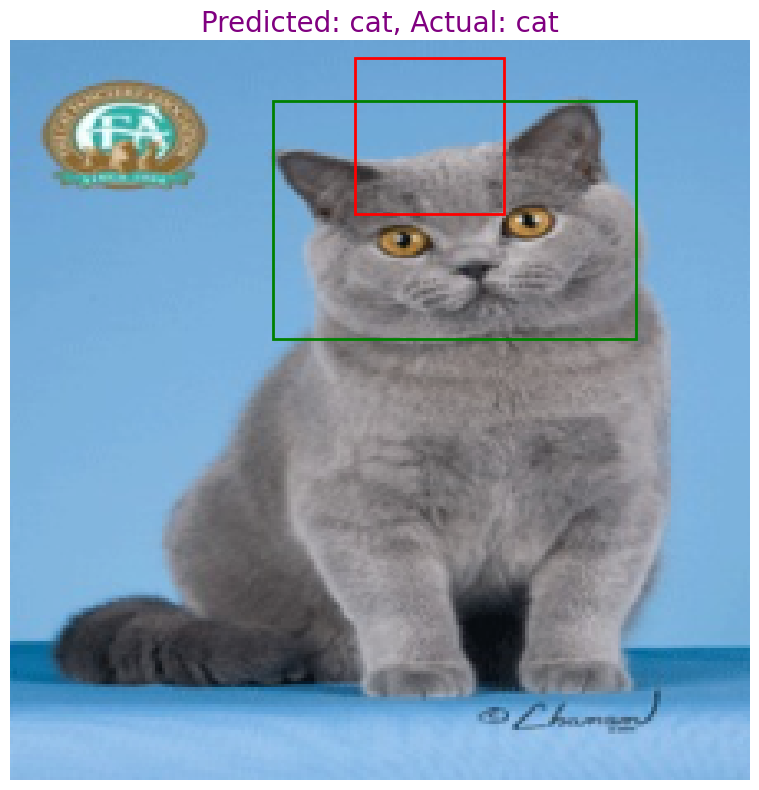

 
-----------------------------------------------------------
| End of Epoch 1 | Time Taken: 67.07572436332703s | Train Accuracy: 0.9428571462631226 | Train loss: 0.27550404230433123, | Val Accuracy: 0.9146341681480408 | Val Loss: 0.2575832176953554 | Average Bounding Box Loss: 0.01694015002188583
 
Epoch 1 Ending...
-----------------------------------------------------------
Starting Epoch 2....
 
| Epoch 2 | 10/93 Batches | 0.9460227489471436 Accuracy
| Epoch 2 | 20/93 Batches | 0.9375 Accuracy
| Epoch 2 | 30/93 Batches | 0.9593750238418579 Accuracy
| Epoch 2 | 40/93 Batches | 0.956250011920929 Accuracy
| Epoch 2 | 50/93 Batches | 0.96875 Accuracy
| Epoch 2 | 60/93 Batches | 0.984375 Accuracy
| Epoch 2 | 70/93 Batches | 0.981249988079071 Accuracy
| Epoch 2 | 80/93 Batches | 0.971875011920929 Accuracy
| Epoch 2 | 90/93 Batches | 0.965624988079071 Accuracy
 


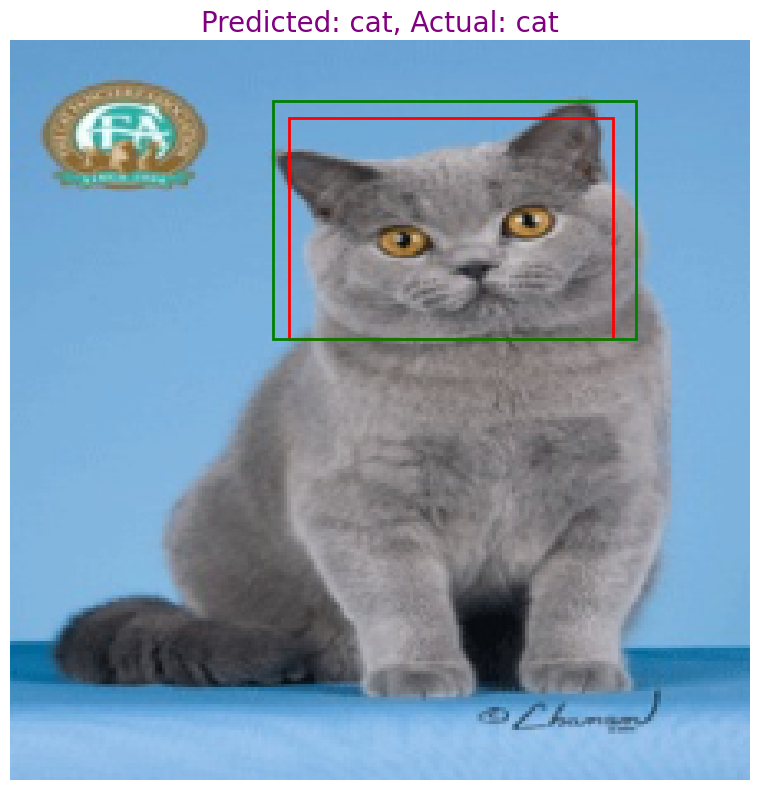

 
-----------------------------------------------------------
| End of Epoch 2 | Time Taken: 42.26498746871948s | Train Accuracy: 0.9428571462631226 | Train loss: 0.11121587337104864, | Val Accuracy: 0.9281842708587646 | Val Loss: 0.17382435981805125 | Average Bounding Box Loss: 0.011276878358330578
 
Epoch 2 Ending...
-----------------------------------------------------------
Starting Epoch 3....
 
| Epoch 3 | 10/93 Batches | 0.9744318723678589 Accuracy
| Epoch 3 | 20/93 Batches | 0.9750000238418579 Accuracy
| Epoch 3 | 30/93 Batches | 0.949999988079071 Accuracy
| Epoch 3 | 40/93 Batches | 0.971875011920929 Accuracy
| Epoch 3 | 50/93 Batches | 0.96875 Accuracy
| Epoch 3 | 60/93 Batches | 0.9781250357627869 Accuracy
| Epoch 3 | 70/93 Batches | 0.9750000238418579 Accuracy
| Epoch 3 | 80/93 Batches | 0.965624988079071 Accuracy
| Epoch 3 | 90/93 Batches | 1.0 Accuracy
 


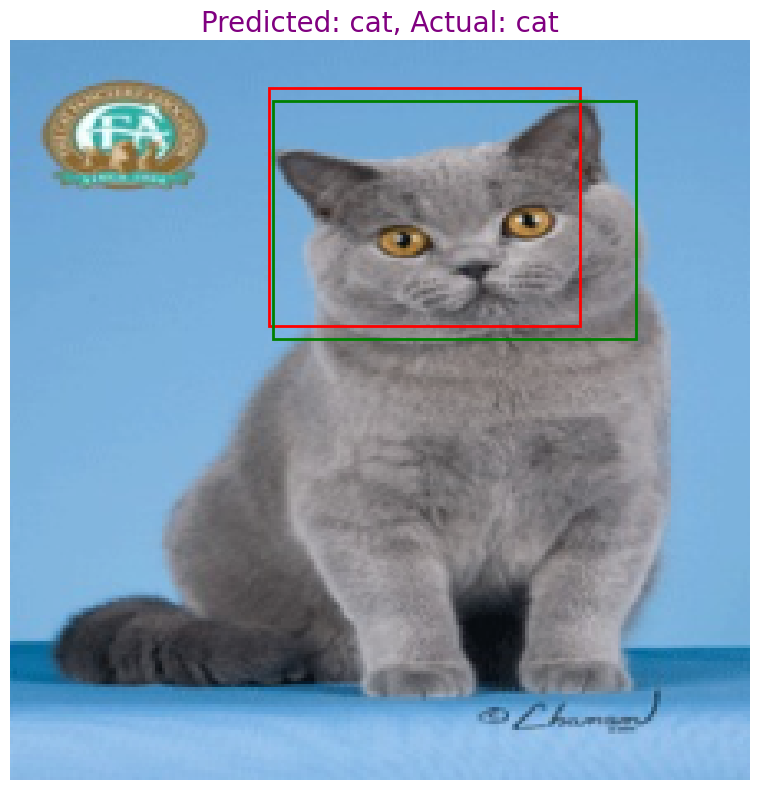

 
-----------------------------------------------------------
| End of Epoch 3 | Time Taken: 40.41066551208496s | Train Accuracy: 0.9428571462631226 | Train loss: 0.08701140835120152, | Val Accuracy: 0.9607046246528625 | Val Loss: 0.17433801557247838 | Average Bounding Box Loss: 0.01009615248767659
 
Epoch 3 Ending...
-----------------------------------------------------------
Starting Epoch 4....
 
| Epoch 4 | 10/93 Batches | 0.9545454978942871 Accuracy
| Epoch 4 | 20/93 Batches | 0.90625 Accuracy
| Epoch 4 | 30/93 Batches | 0.918749988079071 Accuracy
| Epoch 4 | 40/93 Batches | 0.90625 Accuracy
| Epoch 4 | 50/93 Batches | 0.949999988079071 Accuracy
| Epoch 4 | 60/93 Batches | 0.9437500238418579 Accuracy
| Epoch 4 | 70/93 Batches | 0.965624988079071 Accuracy
| Epoch 4 | 80/93 Batches | 0.96875 Accuracy
| Epoch 4 | 90/93 Batches | 0.965624988079071 Accuracy
-----------------------------------------------------------
| End of Epoch 4 | Time Taken: 39.57723665237427s | Train Accuracy: 1.

<ipython-input-17-930d1e31750a>:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))


In [19]:
epochs = 10
save_model = './TwoHeadedModel'
os.makedirs(save_model, exist_ok = True)

ResNet18, metrics = train(
    model, 'TwoHeadedModel', save_model, optim, criterion_cls, criterion_bbs, train_loader, val_loader, epochs, device
)

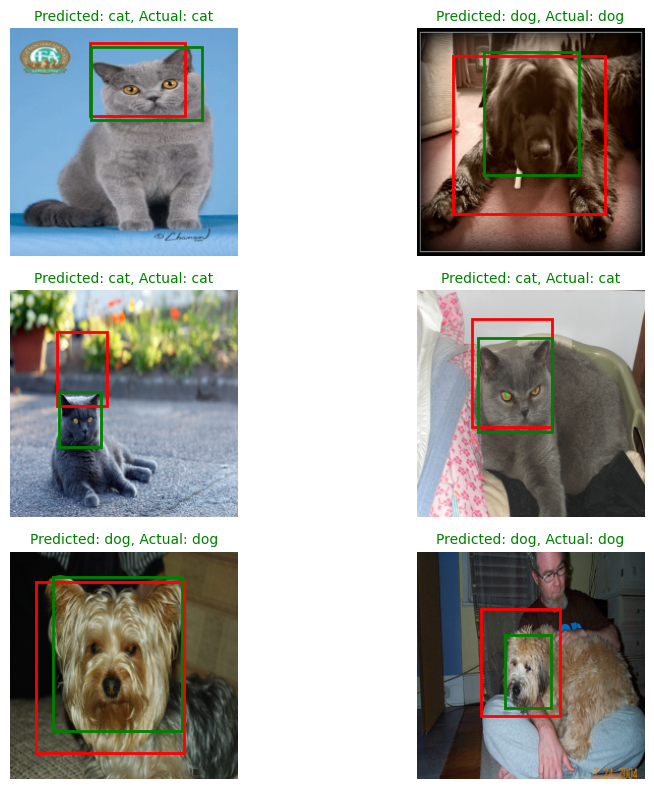

In [20]:
# Function to visualize predictions with bounding boxes
def visualize_predictions_with_bbox(model, dataloader, num_images=6):
    model.eval()
    images_so_far = 0
    class_names = ["cat", "dog"]
    fig = plt.figure(figsize=(10, 8))

    with torch.no_grad():
        for i, (images, labels, bboxes) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            class_outputs, bbox_outputs = model(images)
            _, preds = torch.max(class_outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')

                # Denormalize and display the image
                img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]
                img = std * img + mean
                img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1
                ax.imshow(img)

                # Get predicted bounding box coordinates
                pred_bbox = bbox_outputs[j].cpu().numpy()
                x_min, y_min, x_max, y_max = pred_bbox

                # Scale bounding box coordinates back to image size
                x_min = int(x_min * img.shape[1])
                y_min = int(y_min * img.shape[0])
                x_max = int(x_max * img.shape[1])
                y_max = int(y_max * img.shape[0])

                # Draw the bounding box on the image
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

                # Get ground truth bounding box coordinates
                gt_bbox = bboxes[j].cpu().numpy()
                gt_x_min, gt_y_min, gt_x_max, gt_y_max = gt_bbox

                # Scale ground truth bounding box coordinates back to image size
                gt_x_min = int(gt_x_min * img.shape[1])
                gt_y_min = int(gt_y_min * img.shape[0])
                gt_x_max = int(gt_x_max * img.shape[1])
                gt_y_max = int(gt_y_max * img.shape[0])

                # Draw the ground truth bounding box on the image
                gt_rect = patches.Rectangle((gt_x_min, gt_y_min), gt_x_max - gt_x_min, gt_y_max - gt_y_min, linewidth=2, edgecolor='g', facecolor='none')
                ax.add_patch(gt_rect)

                ax.set_title(
                    f"Predicted: {class_names[preds[j]]}, Actual: {class_names[labels[j]]}",
                    fontdict={
                        "fontsize": 10,
                        "color": "green" if preds[j] == labels[j] else "red",
                    },
                )

                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.show()
                    return

# Visualize some predictions
visualize_predictions_with_bbox(model, val_loader)

train_accuracy: <class 'list'>
eval_accuracy: <class 'list'>
train_losses: <class 'list'>
eval_losses: <class 'list'>


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

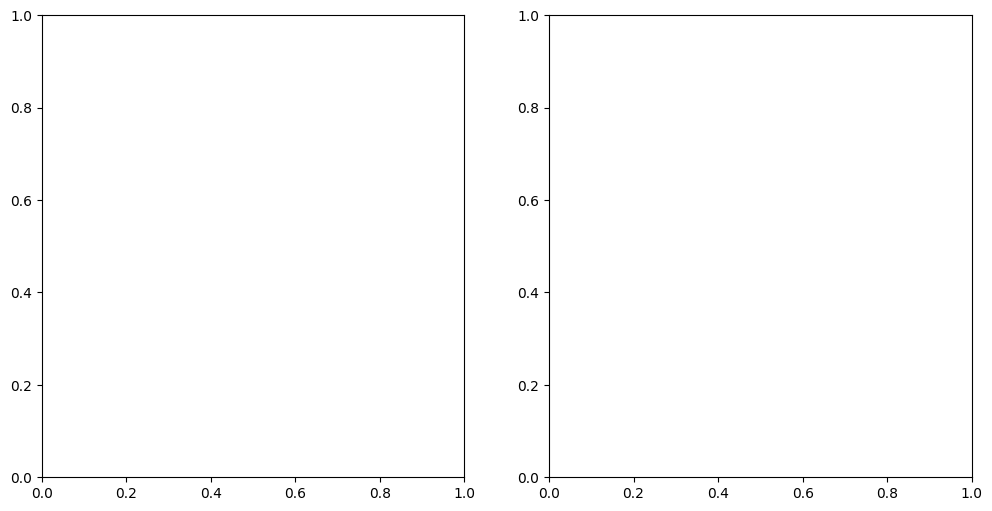

In [21]:
plot_result(
    epochs,
    metrics["Train Accuracy"],
    metrics["Eval Accuracy"],
    metrics["Train Loss"],
    metrics["Eval Loss"]
)